### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


### Prepare the data

Mean Squared Error: 50.71645950413226
Root Mean Squared Error: 7.121548953993946
Mean Absolute Error: 4.120247933884298
R2 Score: 0.9998663238182709


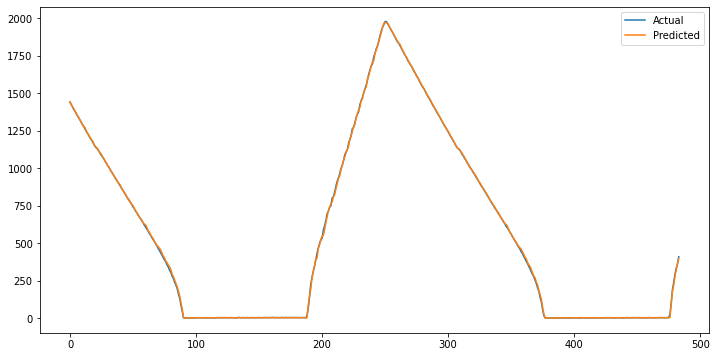

Mean Squared Error: 128.85127128099174
Root Mean Squared Error: 11.351267386551678
Mean Absolute Error: 7.42762396694215
R2 Score: 0.9997120107947057


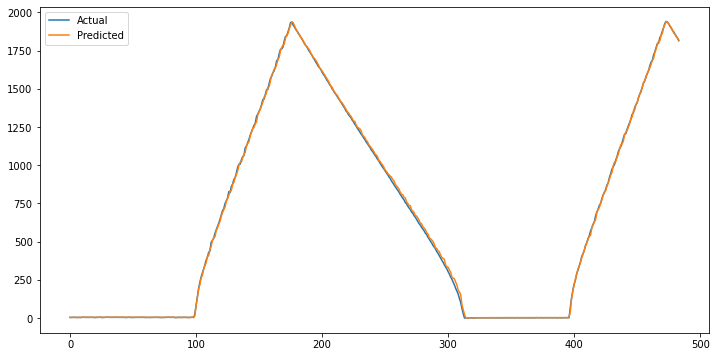

Mean Squared Error: 61.328708057851266
Root Mean Squared Error: 7.831264780215982
Mean Absolute Error: 4.962417355371902
R2 Score: 0.9997261297285025


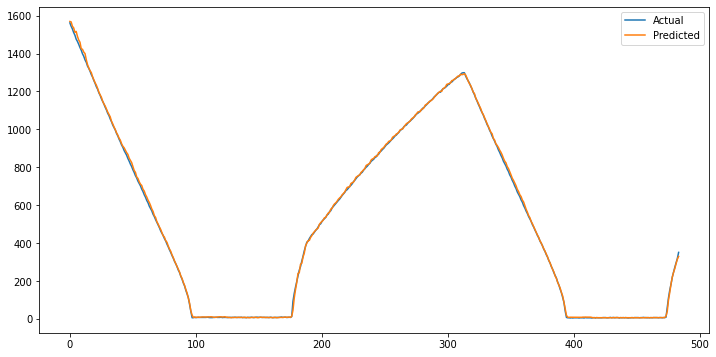

Mean Squared Error: 0.0021521665518824612
Root Mean Squared Error: 0.04639144912462275
Mean Absolute Error: 0.003922176308539945
R2 Score: 0.9902436782239423


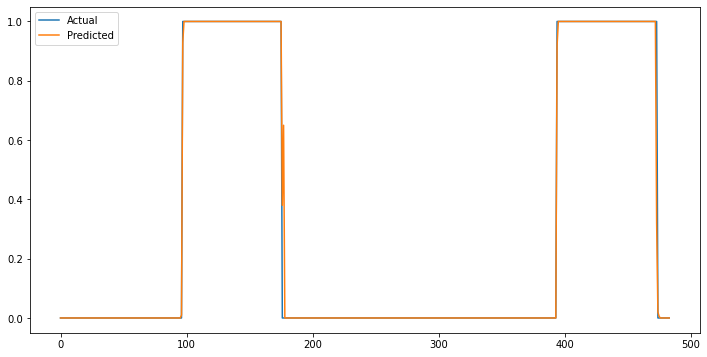

Mean Squared Error: 0.014738636363636363
Root Mean Squared Error: 0.12140278565023277
Mean Absolute Error: 0.04807851239669421
R2 Score: 0.8849243742292437


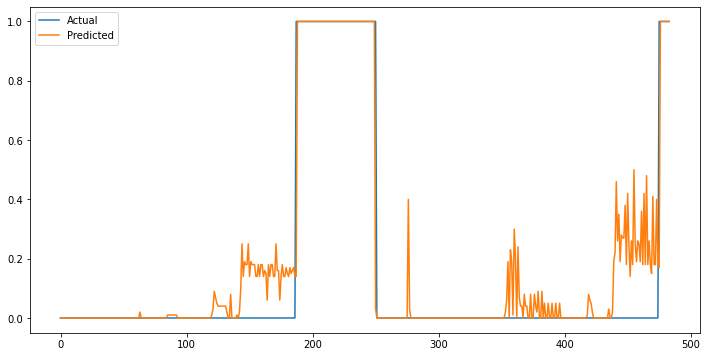

Mean Squared Error: 259199.03156652898
Root Mean Squared Error: 509.1159313619335
Mean Absolute Error: 170.92528925619834
R2 Score: 0.9257301053452847


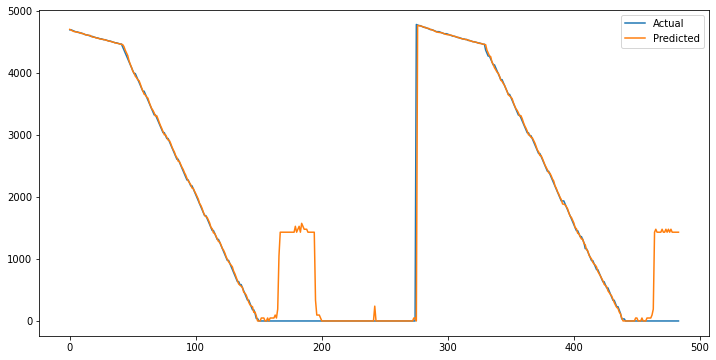

In [2]:
def create_lagged_features_multivariate(df, target_col, lag=1):
    """
    Create lagged features for multivariate time series forecasting.
    
    Parameters:
    df (pd.DataFrame): The multivariate time series data.
    target_col (str): The name of the target column.
    lag (int): The number of lagged features to create.
    
    Returns:
    pd.DataFrame: A DataFrame with lagged features.
    """
    lagged_data = pd.DataFrame()
    for col in df.columns:
        for i in range(1, lag + 1):
            lagged_data[f'{col}_lag_{i}'] = df[col].shift(i)
    
    lagged_data[target_col] = df[target_col]
    lagged_data.dropna(inplace=True)
    return lagged_data

# Example usage:
# Assume `multivariate_data` is a pandas DataFrame containing the multivariate time series data.
file_name = 'phy_cps.csv'
# data = pd.read_csv(file_name, index_col=0, header=0, parse_dates=True)
multivariate_data = pd.read_csv(file_name, index_col=0)
multivariate_data.index.freq = 'ms'
# multivariate_data = pd.DataFrame(...)
features = ['Tank_1', 'Tank_2', 'Tank_3', 'Pump_1', 'Pump_2', 'Flow_sensor']
mse_list = []
rmse_list = []
mae_list = []
rsqr_list = []

for feature in features:    
    # target_column = 'Tank3OutFlow'
    target_column = feature
    lagged_data = create_lagged_features_multivariate(multivariate_data, target_col=target_column, lag=3)
    
    ## Split the data
    # Split the data into train and test sets
    train_size = int(len(lagged_data) * 0.8)
    train, test = lagged_data.iloc[:train_size], lagged_data.iloc[train_size:]
    
    X_train, y_train = train.drop(columns=[target_column]), train[target_column]
    X_test, y_test = test.drop(columns=[target_column]), test[target_column]
    
    
    ## Train the random forest model
    # Initialize and train the Random Forest Regressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    
    ## make predictions and evaluate the model
    # Make predictions
    y_pred = rf_model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mse_list.append(mse)
    print(f'Mean Squared Error: {mse}')
    
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f'Root Mean Squared Error: {rmse}')
    
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print(f'Mean Absolute Error: {mae}')
    
    r_sqr = r2_score(y_test, y_pred)
    rsqr_list.append(r_sqr)
    print(f'R2 Score: {r_sqr}')
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

# for i in len(mae_list):
    

### Forecast Future Values

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature 

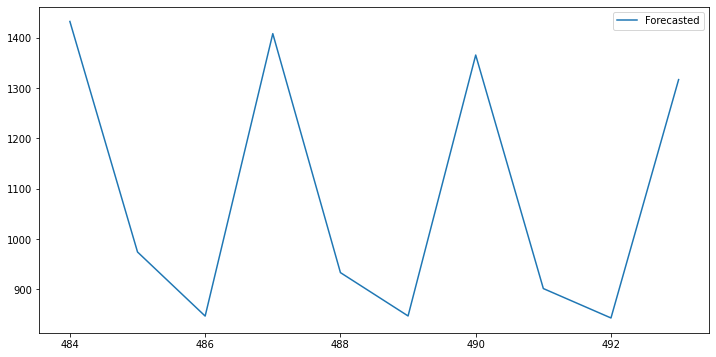

In [3]:
def forecast_future_values_multivariate(model, initial_input, steps=10):
    """
    Forecast future values using the trained model for multivariate time series.
    
    Parameters:
    model: Trained model for forecasting.
    initial_input (np.array): The last observed data point to start forecasting.
    steps (int): The number of future steps to forecast.
    
    Returns:
    list: Forecasted values.
    """
    forecast = []
    current_input = initial_input.copy()
    
    for _ in range(steps):
        prediction = model.predict(current_input.reshape(1, -1))[0]
        forecast.append(prediction)
        
        # Update the input for the next prediction by removing the oldest lag and adding the new prediction
        current_input = np.roll(current_input, -1)
        current_input[-1] = prediction
    
    return forecast

# Example usage:
initial_input = X_test.iloc[-1].values
future_steps = 10
forecasted_values = forecast_future_values_multivariate(rf_model, initial_input, steps=future_steps)

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test), len(y_test) + future_steps), forecasted_values, label='Forecasted')
plt.legend()
plt.show()
